# Model Training: Centers

The task here will be to train a model to predict that value of NHL players who play the Center position. Choice of features is based on the EDA done in 01_C_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [496]:
# Load in our data
filepath = '../../Data/entitiesResolved/merged_data_clean.csv'
data = pd.read_csv(filepath)

## Features to try:

Recall that the EDA done revealed that we should try to use the following features:

1. TOI/GP
2. XGF/60 - and possibly combining it with SCF/60, FF/60, HDCF/60, CF/60, SF/60, and MDCF/60 to create a new feature.
3. GF/60
4. TOTAL ASSISTS/60 - But possibly using FIRST ASSISTS/60 and SECOND_ASSISTS/60 instead.
5. GOALS/60
6. Handedness

In [590]:
# Select all rows were the 'Position' is 'c' or 'c,l' or 'c,r'
centers = data[data['POSITION'].isin(['c', 'c, l', 'c, r'])]

# Select only players with 65 or more games played
centers = centers[(centers['GP'] >= 60)]

# Select only players with a salary cap percentage in the interquartile range
q1 = centers['Y_SALARY_CAP_PERCENTAGE'].quantile(0.25)
q3 = centers['Y_SALARY_CAP_PERCENTAGE'].quantile(0.75)
iqr = q3 - q1

# Remove outliers
test_train_data = centers[(centers['Y_SALARY_CAP_PERCENTAGE'] >= q1 - 1.5 * iqr) & (centers['Y_SALARY_CAP_PERCENTAGE'] <= q3 + 1.5 * iqr)]

# Select the features we want to use
numerical_features = ['TOTAL ASSISTS/60', 'GOALS/60', 'GF/60'] # Removed 'TOI/GP', 'FIRST ASSISTS/60', 'SECOND ASSISTS/60',
categorical_features = []

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

X = test_train_data
y = test_train_data['Y_SALARY_CAP_PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.000786153785078385


In [591]:
# View the coefficients of the model with the name of the features
features = numerical_features + categorical_features
coefficients = pipeline.named_steps['regressor'].coef_
coefficients = [round(coef, 5) for coef in coefficients]
print(dict(zip(features, coefficients)))

{'TOTAL ASSISTS/60': 0.0103, 'GOALS/60': 0.00199, 'GF/60': 0.00874}


In [592]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

In [593]:
# Create a feature column in Centers for the predicted salary
centers['PRED_SALARY_PERCENTAGE'] = pipeline.predict(centers)

# Create a column for the actual predicted salary
centers['PRED_SALARY_CAP_AAV'] = centers['PRED_SALARY_PERCENTAGE'] * centers['Y_SALARY_CAP']

centers['PRED_SALARY_CAP_AAV'] = centers['PRED_SALARY_CAP_AAV'].astype(int)

# Convert Predicted_salary_cap_aav to $
centers['PRED_SALARY_CAP_AAV'] = convert_to_dollars(centers, 'PRED_SALARY_CAP_AAV')

# Convert 'AAV' to $
centers['AAV'] = convert_to_dollars(centers, 'AAV')

In [594]:
# Step 1: Group the data by 'SEASON' and find the minimum value of 'Y_SALARY_CAP_PERCENTAGE' for each season
min_salary_by_season = centers.groupby('SEASON')['Y_SALARY_CAP_PERCENTAGE'].min()

# Step 2: Merge the minimum values back into the original dataframe based on the 'SEASON' column
centers = centers.merge(min_salary_by_season, on='SEASON', suffixes=('', '_MIN'))

# Step 3: Update the predictions in 'PRED_SALARY_PERCENTAGE' column if they are lower than the minimum value
centers['PRED_SALARY_PERCENTAGE'] = centers.apply(lambda row: max(row['PRED_SALARY_PERCENTAGE'], row['Y_SALARY_CAP_PERCENTAGE_MIN']), axis=1)

# Step 4: Update the 'PRED_SALARY_PERCENTAGE' column in the dataframe with the updated predictions
centers['PRED_SALARY_PERCENTAGE'] = centers['PRED_SALARY_PERCENTAGE']


In [595]:
# Select the top 15 centers by predicted salary
top_centers = centers[centers['SEASON'] == '2023-24'].sort_values(by='PRED_SALARY_PERCENTAGE', ascending=False).head(15)
top_centers[['PLAYER', 'SEASON'] + numerical_features + categorical_features + ['Y_SALARY_CAP_PERCENTAGE', 'PRED_SALARY_PERCENTAGE', 'AAV', 'PRED_SALARY_CAP_AAV']]

,PLAYER,SEASON,TOTAL ASSISTS/60,GOALS/60,GF/60,Y_SALARY_CAP_PERCENTAGE,PRED_SALARY_PERCENTAGE,AAV,PRED_SALARY_CAP_AAV
1846,connor mcdavid,2023-24,3.68,1.11,6.12,0.149701,0.125906,"$12,500,000.00","$10,513,174.00"
1892,nathan mackinnon,2023-24,2.85,1.60,6.04,0.150898,0.110888,"$12,600,000.00","$9,259,148.00"
1875,leon draisaitl,2023-24,2.37,1.51,5.51,0.101796,0.095686,"$8,500,000.00","$7,989,773.00"
1861,j.t. miller,2023-24,2.45,1.44,5.29,0.095808,0.094966,"$8,000,000.00","$7,929,632.00"
1856,elias pettersson,2023-24,2.14,1.44,5.25,0.088024,0.088190,"$7,350,000.00","$7,363,825.00"
1823,aleksander barkov,2023-24,2.38,0.89,4.80,0.119760,0.085905,"$10,000,000.00","$7,173,025.00"
1925,sebastian aho,2023-24,2.24,1.24,4.80,0.101320,0.085064,"$8,460,250.00","$7,102,879.00"
1835,brayden point,2023-24,1.64,1.73,5.41,0.113772,0.080971,"$9,500,000.00","$6,761,113.00"
1914,ryan nugent-hopkins,2023-24,1.98,0.74,5.11,0.061377,0.079509,"$5,125,000.00","$6,638,967.00"
1838,carter verhaeghe,2023-24,1.74,1.45,5.08,0.049900,0.078448,"$4,166,667.00","$6,550,369.00"


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Centers')

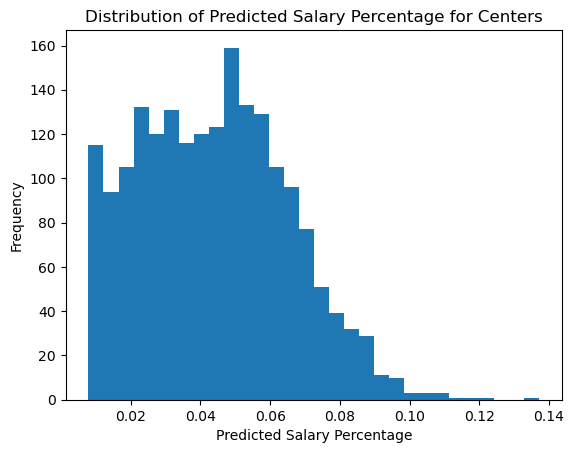

In [515]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(centers['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Centers')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Centers')

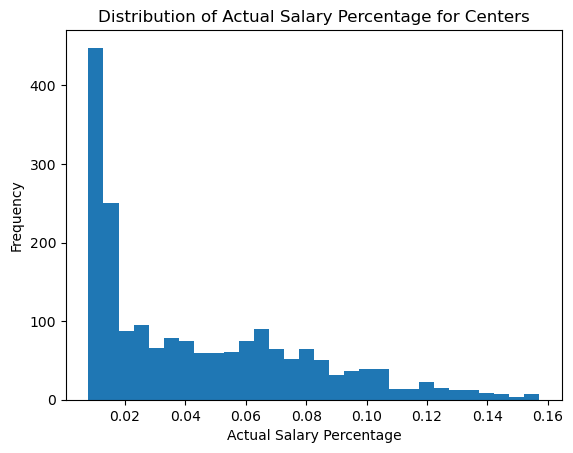

In [506]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(centers['Y_SALARY_CAP_PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Centers')

# Preliminary Conclusions
It seems like we need to make some tweaks. I can see two ways to think about this:
1. We're missing something in our feature set that predicts how valuable players like Connor Mcdavid and Nathan Mackinnon really are.
2. Our model thinks that the highest paid players are significantly overpaid considering how well they produce on the ice.